# Data processing

# Libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import LearningCurveDisplay

from tqdm import tqdm

import warnings
from sklearn.exceptions import DataConversionWarning

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

from category_encoders import BinaryEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer

import optuna
from optuna.samplers import TPESampler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from settings import MODEL_PIPE, RKF

warnings.simplefilter(action='ignore', category=DataConversionWarning)
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

# Data Loading

In [ ]:
X_test = pd.read_parquet(f"../../../../../data/interim/copper/X_test.parquet")
y_test = pd.read_parquet(f"../../../../../data/interim/copper/y_test_cat.parquet")

X_train = pd.read_parquet(f"../../../../../data/interim/copper/X_train.parquet")
y_train = pd.read_parquet(f"../../../../../data/interim/copper/y_train_cat.parquet")

# Hyperparameter Setting

In [4]:
study = optuna.load_study(storage='sqlite:///decision_tree_model.db')

TypeError: load_study() missing 1 required keyword-only argument: 'study_name'

In [17]:
plot_optimization_history(study)

In [18]:
#optuna.visualization.plot_pareto_front(study, target_names=["mean ROC-AUC", "std ROC-AUC"])

In [19]:
plot_param_importances(study)

In [20]:
params = study.best_params
params

{'n_estimators': 247,
 'max_depth': 5,
 'learning_rate': 0.11460458768157133,
 'min_child_weight': 3,
 'gamma': 0.3154154196249262,
 'subsample': 0.7255104129593144,
 'colsample_bytree': 0.7847235791615856,
 'reg_alpha': 0.10753639077178752,
 'reg_lambda': 0.21040818574364079,
 'importance_type': 'cover',
 'random_state': 53}

# Learning Curve

In [22]:
over = SMOTE(sampling_strategy="auto")
under = RandomUnderSampler(sampling_strategy="auto")

numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('imputer', KNNImputer(n_neighbors=5)),
        ('pca', PCA(n_components=len(NUM_SELECTED)))
    ])

categorical_transformer = Pipeline(steps=[
    ('binary_encoder', BinaryEncoder())
])

preprocessor = ColumnTransformer(
        transformers=[
            ('num_pca', numeric_transformer, NUM_SELECTED),
            ('cat', categorical_transformer, ["GLOBAL_REGION"])
        ]
    )

steps_list =[('preprocessor', preprocessor),
        ('over', over),
        ('under', under),]


model = XGBClassifier(**params)

steps_list.append(('classifier', model))

pipe = ImbPipeline(steps_list)

In [23]:
common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.01, 1, 100),
    "cv": RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=42),
    "scoring": "roc_auc",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
}

Text(0.5, 1.0, 'Learning Curve for XGBClassifier')

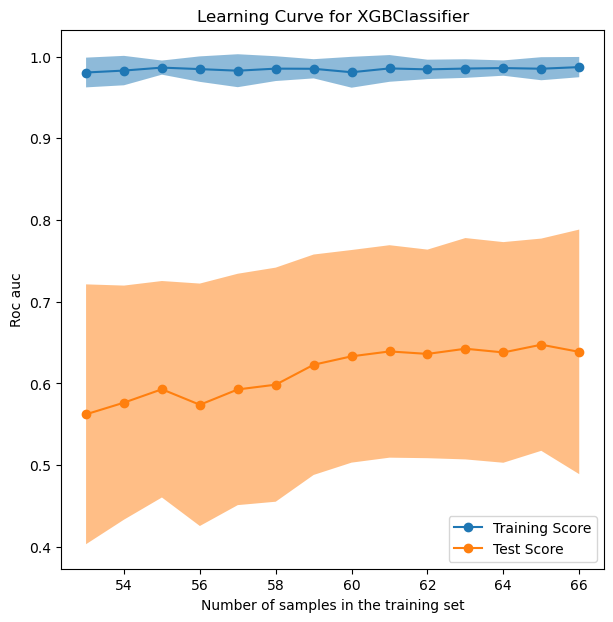

In [24]:
fig, ax = plt.subplots(figsize=(7, 7), sharey=True)

LearningCurveDisplay.from_estimator(pipe, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {model.__class__.__name__}")

# Bootstraping Error Extimation

In [25]:
pipe.fit(X_train[NUM_SELECTED + ["GLOBAL_REGION"]], y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pca',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   KNNImputer()),
                                                                  ('pca',
                                                                   PCA(n_components=7))]),
                                                  ['COPPER_GRADE',
                                                   'INITIAL_COST',
                                                   'LOG_10_COPPER_GRADE',
                                                   'LOG_10_GOLD_DENSITY',
                                                   'INITIAL_COST_PER_TONNE',
                                                   'LOG_10_INITIAL_COST',
                                                   'GOLD_DENSITY']),
                                                 ('cat',
                                                  Pipeline(steps=[('binary_encod...
                               grow_policy=None, importance_type='cover',
                               interaction_constraints=None,
                               learning_rate=0.11460458768157133, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=5,
                               max_leaves=None, min_child_weight=3, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=247, n_jobs=None,
                               num_parallel_tree=None, random_state=53, ...))])

## Treino

In [26]:
y_prob = pipe.predict_proba(X_train)[:, 1]

roc_auc = roc_auc_score(y_train.values, y_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")

ROC AUC Score: 0.9937


In [29]:
bootstrap_dataframes = [X_train.sample(X_train.shape[0], replace=True) for _ in range(1000)]

lines = []
roc_auc_scores = []

for i, df in tqdm(enumerate(bootstrap_dataframes)):

    y_prob = pipe.predict_proba(df)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_train.loc[df.index].values, y_prob)
    line_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds, 'Bootstrap': i})
    lines.append(line_df)

    roc_auc = roc_auc_score(y_train.loc[df.index].values, y_prob)
    roc_auc_scores.append(roc_auc)

roc_df = pd.concat(lines)

0it [00:00, ?it/s]

1000it [00:09, 100.83it/s]


<Axes: ylabel='Count'>

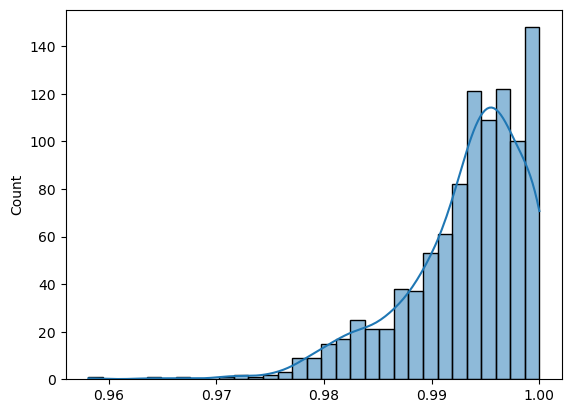

In [28]:
sns.histplot(roc_auc_scores, kde=True)

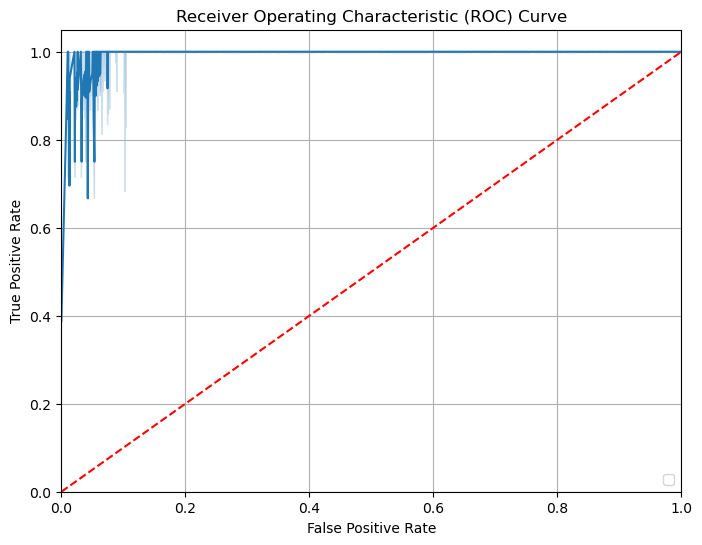

In [30]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='FPR', y='TPR', data=roc_df, estimator='median')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Teste

In [31]:
y_prob = pipe.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test.values, y_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")

ROC AUC Score: 0.6333


In [32]:
bootstrap_dataframes = [X_test.sample(X_test.shape[0], replace=True) for _ in range(1000)]

def get_bootstrap_roc_curve(pipe, df, y_test, i):

    y_prob = pipe.predict_proba(df)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test.loc[df.index].values, y_prob)
    line_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds, 'Bootstrap': i})

    return line_df

lines = [get_bootstrap_roc_curve(pipe, df, y_test, i) for i, df in tqdm(enumerate(bootstrap_dataframes))]

def get_roc_auc(pipe, df, y_test):
    y_prob = pipe.predict_proba(df)[:, 1]
    roc_auc = roc_auc_score(y_test.loc[df.index].values, y_prob)
    return roc_auc

roc_auc_scores = [get_roc_auc(pipe, df, y_test) for df in tqdm(bootstrap_dataframes)]

roc_df = pd.concat(lines)


0it [00:00, ?it/s]

1000it [00:11, 84.94it/s]
100%|██████████| 1000/1000 [00:08<00:00, 115.35it/s]


<Axes: ylabel='Count'>

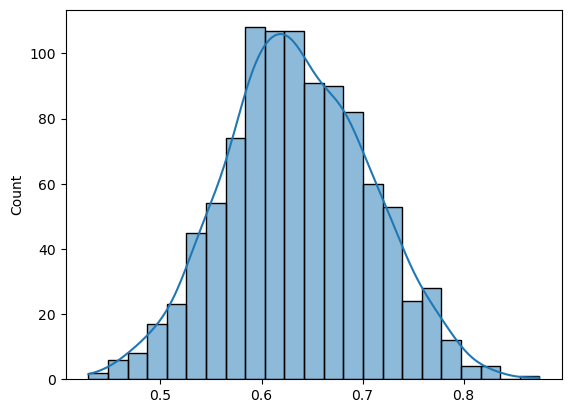

In [33]:
sns.histplot(roc_auc_scores, kde=True)

In [34]:
np.quantile(roc_auc_scores, [0.05, 0.5, 0.95])

array([0.52309198, 0.63261244, 0.75781265])

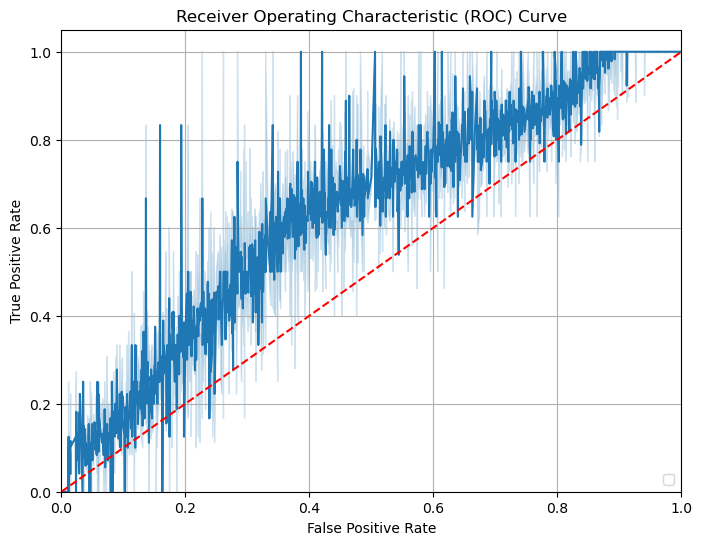

In [35]:
# Step 7: Plot the ROC curve
plt.figure(figsize=(8, 6))
sns.lineplot(x='FPR', y='TPR', data=roc_df, estimator='median')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()